# Model Building

Build logistic regression model for Domestic office deposits_Avg_growth_ratio.

In [1]:
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LogisticRegression
import pandas as pd

y = 'Domestic office deposits_Avg_growth_ratio'
col_deposits = ['Domestic office deposits', 
                'Interest-bearing deposits', 
                'Noninterest-bearing deposits', 
                'Time deposits']

## Data Preparation

### Split Data

Last 6 timekeys for OOT, all others as training

In [2]:
df = pd.read_csv('data/full_modeling.csv').sort_values('timekey').reset_index(drop=True)
df = df[~df[y].isnull()]

targets = [col for col in df.columns if 'deposits' in col]
cols_X = df.columns
for target in col_deposits + ['timekey']:
    cols_X = [col for col in cols_X if target not in col]

y_l, y_h = 0.98, 1.1
def f(x):
    return (x - y_l)/(y_h - y_l)
def f_inv(x):
    return y_l + (y_h - y_l)*x
df['y'] = df[y].apply(f)

oot_data, train_data = df.tail(6), df.iloc[:-6]
X_oot, y_oot = oot_data[cols_X], oot_data['y']

### Parceling

Convert bounded continuous target to binary target with weight.

In [3]:
df_label1 = train_data.copy()
df_label1['label'] = 1
df_label1['weight'] = df_label1['y']

df_label0 = train_data.copy()
df_label0['label'] = 0
df_label0['weight'] = 1 - df_label0['y']

df_parceled = pd.concat([df_label1, df_label0], ignore_index=True)
X_train = df_parceled[cols_X]
y_train = df_parceled['label']
weights_train = df_parceled['weight']
print(X_train.shape)

(158, 255)


### Data preprocessing

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
import numpy as np
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed, columns=cols_X, index=X_train.index)

X_oot_processed = preprocessor.fit_transform(X_oot)
X_oot_processed = pd.DataFrame(X_oot_processed, columns=cols_X, index=X_oot.index)

## Fit Model
### Feature selection with L1

In [5]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression with L1 penalty for feature selection
logistic_l1 = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=1,  
    max_iter=100000,
    tol=1e-3,
    random_state=42
)
logistic_l1.fit(X_train_processed, y_train, sample_weight=weights_train)

coefficients = pd.DataFrame({
    'Feature': cols_X,
    'Coefficient': logistic_l1.coef_.ravel()  # Use .ravel() since LogisticRegression returns 2D array
}).sort_values('Coefficient', ascending=False, key=abs).reset_index(drop=True)
coefficients = coefficients[coefficients['Coefficient']!=0]
print(coefficients)  

                  Feature  Coefficient
0                 M2_ROC1     0.133729
1                 PCE_QOQ    -0.104176
2                 M1_LAG8    -0.099848
3         TREASURY_3M_CHG    -0.096398
4   HOUSE_PRICE_INDEX_QOQ     0.089797
5             M2_YOY_LAG4    -0.045697
6                  M2_QOQ     0.043200
7                  M2_YOY     0.030869
8        TREASURY_30Y_CHG    -0.018933
9     PERSONAL_INCOME_YOY     0.016444
10       RETAIL_SALES_YOY     0.015544
11           CPI_QOQ_LAG4    -0.011521
12  TREASURY_10Y_CHG_LAG4    -0.006990


### Logistic Regression with Selected Feature

In [6]:
cols_X_short = coefficients['Feature'].tolist()
cols_X_short = [col for col in cols_X_short if col not in ['M2_ROC1']]
X_train_processed_short = X_train_processed[cols_X_short]

logistic = LogisticRegression(penalty='none',max_iter=20000)
logistic.fit(X_train_processed_short, y_train, sample_weight=weights_train)

all_params = np.concatenate([logistic.coef_.ravel(), logistic.intercept_])
coef_df = pd.DataFrame({
    "feature": cols_X_short+['intercept'],
    "coefficient": all_params})
print(coef_df)

                  feature  coefficient
0                 PCE_QOQ    -0.271215
1                 M1_LAG8    -0.155636
2         TREASURY_3M_CHG    -0.143530
3   HOUSE_PRICE_INDEX_QOQ     0.217780
4             M2_YOY_LAG4    -0.150782
5                  M2_QOQ     0.157582
6                  M2_YOY     0.076210
7        TREASURY_30Y_CHG    -0.028863
8     PERSONAL_INCOME_YOY     0.022779
9        RETAIL_SALES_YOY     0.174150
10           CPI_QOQ_LAG4    -0.032525
11  TREASURY_10Y_CHG_LAG4    -0.017421
12              intercept    -0.935323


### Model performance

### MultiColinearity Check

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

vif = calculate_vif(X_train_processed_short)
print(f"Variance Inflation Factor:\n{vif}")

Variance Inflation Factor:
                  Feature       VIF
9        RETAIL_SALES_YOY  4.516573
8     PERSONAL_INCOME_YOY  3.013727
6                  M2_YOY  2.967152
0                 PCE_QOQ  2.516457
5                  M2_QOQ  2.324334
10           CPI_QOQ_LAG4  1.932300
1                 M1_LAG8  1.874667
2         TREASURY_3M_CHG  1.793689
3   HOUSE_PRICE_INDEX_QOQ  1.792858
4             M2_YOY_LAG4  1.741646
11  TREASURY_10Y_CHG_LAG4  1.600625
7        TREASURY_30Y_CHG  1.529885


### Mean absolute error

In [8]:
y_pred_train = logistic.predict_proba(X_train_processed_short)[:, 1]
valid_train = pd.DataFrame({'y_pred':y_pred_train, 'w':weights_train})[y_train==1]
valid_train['y_pred_scaled'] =  valid_train['y_pred'].apply(f_inv)
valid_train['w_scaled'] = valid_train['w'].apply(f_inv)

y_pred_oot = logistic.predict_proba(X_oot_processed[cols_X_short])[:, 1]
valid_oot = pd.DataFrame({'y_pred':y_pred_oot, 'w':y_oot})
valid_oot['y_pred_scaled'] = valid_oot['y_pred'].apply(f_inv)
valid_oot['w_scaled'] = valid_oot['w'].apply(f_inv)

maes = {}
maes['train'] = np.mean(np.abs(valid_train['w_scaled'] - valid_train['y_pred_scaled']))
maes['oot'] = np.mean(np.abs(valid_oot['w_scaled'] - valid_oot['y_pred_scaled']))

print('Mean Absolute Error')
print(maes)

Mean Absolute Error
{'train': 0.0056352461023128795, 'oot': 0.007875988786832952}


### Backtesting

- Calculate deposits from predicted growth

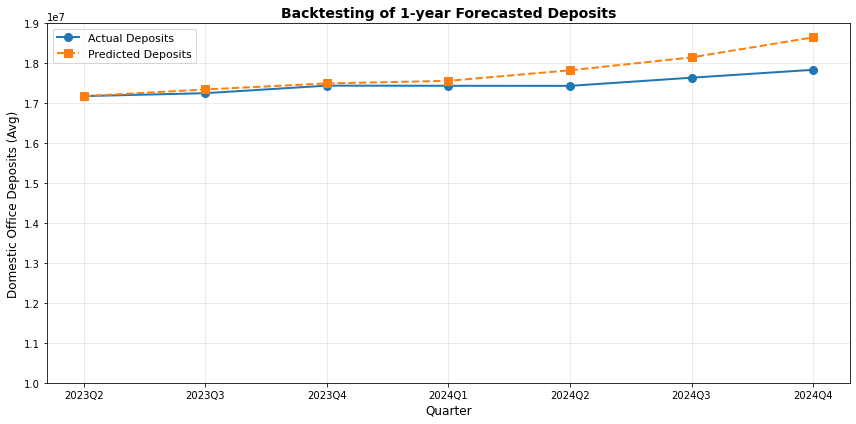


Backtesting Results ($MM):
   quarter  Domestic office deposits_Avg  Domestic office deposits_Avg_pred
78  2023Q2                        17.179                             17.179
79  2023Q3                        17.253                             17.345
80  2023Q4                        17.441                             17.497
81  2024Q1                        17.438                             17.562
82  2024Q2                        17.436                             17.826
83  2024Q3                        17.640                             18.149
84  2024Q4                        17.838                             18.651


In [9]:
from utils import plot_bt, timekey_to_quarter
import matplotlib.pyplot as plt

deposits_col = y[:-13]
pred_col = deposits_col + '_pred'
bt = df.tail(6+1)[['timekey', deposits_col, y]]
bt[pred_col] = np.nan

bt.loc[bt.index[0], pred_col] = bt.loc[bt.index[0], deposits_col]
starting_value = bt[pred_col].iloc[0]
predicted_growth_ratios = valid_oot['y_pred_scaled'].values
bt.loc[bt.index[1:5], pred_col] = starting_value * np.cumprod(predicted_growth_ratios[:4])

# t+5: Start from actual value at t+1 (index 1)
starting_value_2 = bt.loc[bt.index[1], deposits_col]
bt.loc[bt.index[5], pred_col] = starting_value_2 * np.prod(predicted_growth_ratios[1:5])

# t+6: Start from actual value at t+2 (index 2)
starting_value_3 = bt.loc[bt.index[2], deposits_col]
bt.loc[bt.index[6], pred_col] = starting_value_3 * np.prod(predicted_growth_ratios[2:6])

bt['quarter'] = bt['timekey'].apply(lambda x: timekey_to_quarter(x))


fig = plot_bt(bt, deposits_col, pred_col)
plt.show()
print("\nBacktesting Results ($MM):")
bt = bt.applymap(lambda x: round(x/1000000,3) if not isinstance(x,str) else x)
print(bt[['quarter', deposits_col, pred_col]])